# Análisis de NLP en Datos Hospitalarios

## Introducción
Este notebook tiene como objetivo aplicar técnicas de Procesamiento del Lenguaje Natural (NLP) al dataset `hado_final.csv` para extraer insights que puedan ser útiles en el ámbito hospitalario. El análisis se centrará en las columnas que contienen datos de texto, como diagnósticos, motivos de ingreso y alta, entre otros.

## Carga y Exploración Inicial de Datos
El primer paso es cargar el conjunto de datos y realizar una exploración inicial para entender la estructura y el tipo de datos que contiene.

In [1]:
# Importar las bibliotecas necesarias
import pandas as pd
import numpy as np

%load_ext kedro.ipython
# Cargar el conjunto de datos
# hado_data = pd.read_csv('hado_final.csv', sep=',')
hado_data = catalog.load("hado_final")
# Inspeccionar las primeras filas del conjunto de datos
hado_data.head()

[09/14/23 17:40:04] INFO     Resolved project path as: c:\Users\Pablo                               __init__.py:136
                             Villar\Desktop\CURSOS\KSchool\Máster en Data                                          
                             Science\TFM\nuevo_entorno_kedro\hado.                                                 
                             To set a different path, run '%reload_kedro <project_root>'                           

[09/14/23 17:40:05] WARNING  C:\Users\Pablo                                                         warnings.py:109
                             Villar\AppData\Local\Programs\Python\Python310\lib\importlib\__init__.                
                             py:126: DeprecationWarning: `kedro.extras.datasets` is deprecated and                 
                             will be removed in Kedro 0.19, install `kedro-datasets` instead by                    
                             running `pip install kedro-datasets`.                                                 
                               return _bootstrap._gcd_import(name[level:], package, level)                         
                                                                                                                   

[09/14/23 17:40:06] INFO     Kedro project hado                                                     __init__.py:105

                    INFO     Defined global variable 'context', 'session', 'catalog' and            __init__.py:106
                             'pipelines'                                                                           

[09/14/23 17:40:07] INFO     Registered line magic 'run_viz'                                        __init__.py:112

                    INFO     Loading data from 'hado_final' (CSVDataSet)...                     data_catalog.py:345

h_procedencia hospital_category s_procedencia procedencia_category  \
0   gil casares          Santiago          upal    Unidad Paliativos   
1       clinico          Santiago     oncologia            Oncologia   
2       clinico          Santiago           mir                  MIR   
3       clinico          Santiago     digestivo            Digestivo   
4       clinico          Santiago     urgencias            Urgencias   

                    diagnostico        diagnosis_category  \
0                    cancer orl     Canceres y neoplasias   
1               melanoma vulvar              Neurologicas   
2           cancer broncogenico     Canceres y neoplasias   
3             cirrosis hepatica  Hepaticas y pancreaticas   
4  neoplasia de mama estadio IV     Canceres y neoplasias   

                  motivo_ing ingreso_category   motivo_alta   alta_category  \
0           control sintomas         Sintomas     reingreso  Complicaciones   
1          mal control dolor         Sintomas        exitus          Exitus   
2          control evolutivo     Evaluaciones  fin cuidados           Otros   
3  administracion octreotido            Otros  fin cuidados           Otros   
4           control sintomas         Sintomas        exitus          Exitus   

   ...   categorized_combined_otros tiene_sedacion  morfina  midazolam  \
0  ...                        Otros              0        0          0   
1  ...                        Otros              0        0          0   
2  ...  Desconocido/No especificado              0        0          0   
3  ...  Desconocido/No especificado              0        0          0   
4  ...  Desconocido/No especificado              0        0          0   

  buscapina haloperidol levomepromazina        medico ayuntamiento  year  
0         0           0               0        valdes  desconocido  2017  
1         0           0               0   galego feal  desconocido  2017  
2         0           0               0  lopez renedo  desconocido  2017  
3         0           0               0  lopez renedo  desconocido  2017  
4         0           0               0  lopez renedo  desconocido  2017  

[5 rows x 50 columns]

## Exploración Inicial de Datos

Ahora que hemos cargado el conjunto de datos, el siguiente paso es realizar una exploración inicial. Esto nos permitirá identificar qué columnas contienen datos de texto que podrían beneficiarse de técnicas de NLP.

Empezaremos por obtener un resumen estadístico del conjunto de datos y examinar los tipos de datos de cada columna.

In [2]:
# Obtener un resumen estadístico del conjunto de datos
hado_data.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
h_procedencia,4013,17,clinico,2240,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hospital_category,4013,3,Santiago,2747,NaN,NaN,NaN,NaN,NaN,NaN,NaN
s_procedencia,4013,100,no,1225,NaN,NaN,NaN,NaN,NaN,NaN,NaN
procedencia_category,4013,10,Otros,1700,NaN,NaN,NaN,NaN,NaN,NaN,NaN
diagnostico,4013,1514,ITU (infeccion del tracto urinario),172,NaN,NaN,NaN,NaN,NaN,NaN,NaN
diagnosis_category,4013,10,Otros,955,NaN,NaN,NaN,NaN,NaN,NaN,NaN
motivo_ing,4013,560,control sintomas,1229,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ingreso_category,4013,4,Sintomas,1402,NaN,NaN,NaN,NaN,NaN,NaN,NaN
motivo_alta,4013,90,fin cuidados,2380,NaN,NaN,NaN,NaN,NaN,NaN,NaN
alta_category,4013,4,Otros,2473,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# Examinar los tipos de datos de cada columna
hado_data.dtypes

h_procedencia                 object
hospital_category             object
s_procedencia                 object
procedencia_category          object
diagnostico                   object
diagnosis_category            object
motivo_ing                    object
ingreso_category              object
motivo_alta                   object
alta_category                 object
fecha_alta                    object
ap                            object
n_estancias                    int64
n_visitas                      int64
paliativo_onc_noc             object
paliativo_no_onc_noc          object
fiebre                        object
disnea                        object
dolor                         object
delirium                      object
sedacion                      object
p_terminal                    object
agonia                        object
ast_anorx                     object
cronico_reag                  object
trato_antibiotico             object
transfusion                   object
p

## Selección de Columnas y Preparación de Datos

Con la exploración inicial completa, podemos identificar las columnas que contienen datos de texto y que son candidatas para aplicar técnicas de NLP. Estas columnas suelen contener información como diagnósticos, motivos de ingreso y alta, entre otros.

El siguiente paso es preparar estos datos para el análisis de NLP. Esto puede incluir tareas como la limpieza de texto, la eliminación de caracteres especiales y la tokenización.

## Limpieza y Preprocesamiento de Texto

Antes de aplicar cualquier técnica de NLP, es crucial preparar y limpiar los datos de texto. Esto asegura que el modelo pueda entender los datos de manera efectiva. Los pasos comunes en la limpieza de texto incluyen:

- Convertir todo el texto a minúsculas.
- Eliminar caracteres especiales y números.
- Tokenización: dividir el texto en palabras o tokens.

Empezaremos por aplicar estos pasos a las columnas seleccionadas.

In [21]:
hado_data['diagnostico'].value_counts()

itu infeccion tracto urinario    172
infeccion respiratoria           145
infeccion urinaria               113
cancer pulmon                     94
cancer colon                      93
                                ... 
hemorragia subaracnoidea           1
iitu repeticion                    1
neoplasia mieloproliferativa       1
adenocarcinoma hepatobilniar       1
pseudoartrosis tibia               1
Name: diagnostico, Length: 1451, dtype: int64

* `punkt` es el tokenizer preentrenado para dividir texto en oraciones y palabras. 
  >Es especialmente útil para idiomas como el inglés donde las palabras pueden ser tokenizadas dividiéndolas en espacios en blanco y signos de puntuación. El tokenizer `punkt` es utilizado por funciones de nltk como sent_tokenize y word_tokenize.

In [4]:
# Importar las bibliotecas necesarias para el preprocesamiento de texto
import re
# %pip install nltk
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize

# Función para limpiar y preprocesar el texto
def clean_text(text):
    text = text.lower()  # Convertir a minúsculas
    text = re.sub(r'[^a-zA-Z]', ' ', text)  # Eliminar caracteres especiales y números
    words = word_tokenize(text)  # Tokenización
    words = [word for word in words if word not in stopwords.words('spanish')]  # Eliminar stopwords
    return ' '.join(words)

# Aplicar la limpieza de texto a las columnas seleccionadas (por ejemplo, 'diagnostico', 'motivo_ing', 'motivo_alta')
text_columns = ['diagnostico', 'motivo_ing', 'motivo_alta']
for col in text_columns:
    hado_data[col] = hado_data[col].astype(str).apply(clean_text)

# Inspeccionar las primeras filas para verificar la limpieza
hado_data[text_columns].head()

[nltk_data] Downloading package punkt to C:\Users\Pablo
[nltk_data]     Villar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Pablo
[nltk_data]     Villar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,diagnostico,motivo_ing,motivo_alta
0,cancer orl,control sintomas,reingreso
1,melanoma vulvar,mal control dolor,exitus
2,cancer broncogenico,control evolutivo,fin cuidados
3,cirrosis hepatica,administracion octreotido,fin cuidados
4,neoplasia mama estadio iv,control sintomas,exitus


In [22]:
import spacy

# Cargar el modelo de spaCy (usaremos el modelo base por las restricciones del entorno)
nlp = spacy.blank('es')

def clean_text_spacy(text):
    text = text.lower()  # Convertir a minúsculas
    text = re.sub(r'[^a-zA-Z]', ' ', text)  # Eliminar caracteres especiales y números
    doc = nlp(text)  # Procesar el texto con spaCy
    words = [token.text for token in doc if token.text not in stopwords.words('spanish')]  # Eliminar stopwords
    return ' '.join(words)

# Aplicar la limpieza de texto con spaCy a las columnas seleccionadas
for col in text_columns:
    hado_data[col] = hado_data[col].astype(str).apply(clean_text_spacy)

# Inspeccionar las primeras filas para verificar la limpieza
hado_data[text_columns].head()

,diagnostico,motivo_ing,motivo_alta
0,cancer orl,control sintomas,reingreso
1,melanoma vulvar,mal control dolor,exitus
2,cancer broncogenico,control evolutivo,fin cuidados
3,cirrosis hepatica,administracion octreotido,fin cuidados
4,neoplasia mama estadio iv,control sintomas,exitus


## Análisis de NLP

Con los datos de texto limpios y preprocesados, estamos listos para aplicar técnicas de NLP. En este análisis, exploraremos las siguientes técnicas:

- **Análisis de Frecuencia de Palabras**: Identificar las palabras más comunes en cada columna de texto.
- **Análisis de Sentimiento**: Aunque este enfoque es más común en reseñas y comentarios, podría ofrecer alguna intuición en el contexto hospitalario.
- **Clustering**: Agrupar registros similares basados en el texto.

Empezaremos con el Análisis de Frecuencia de Palabras.

Análisis de frecuencia de palabras para la columna diagnostico


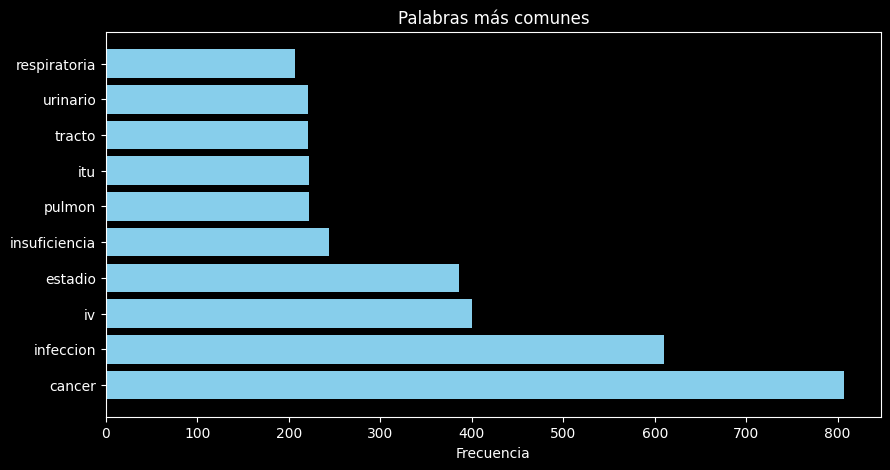

Análisis de frecuencia de palabras para la columna motivo_ing


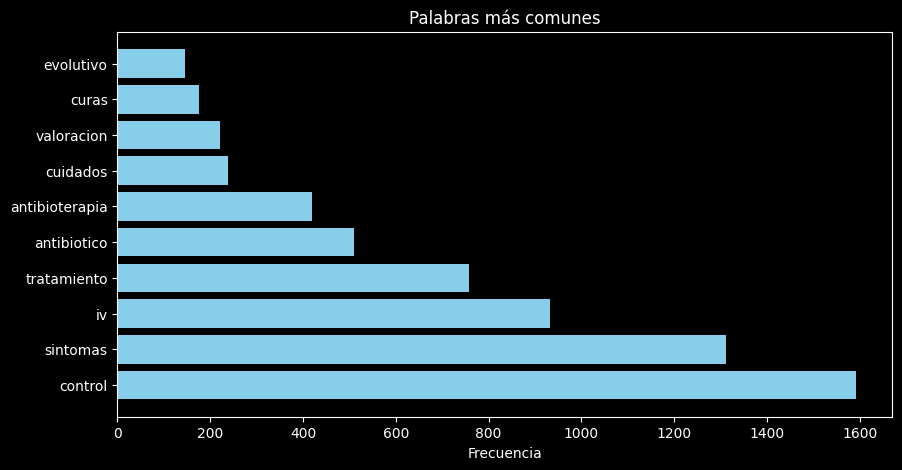

Análisis de frecuencia de palabras para la columna motivo_alta


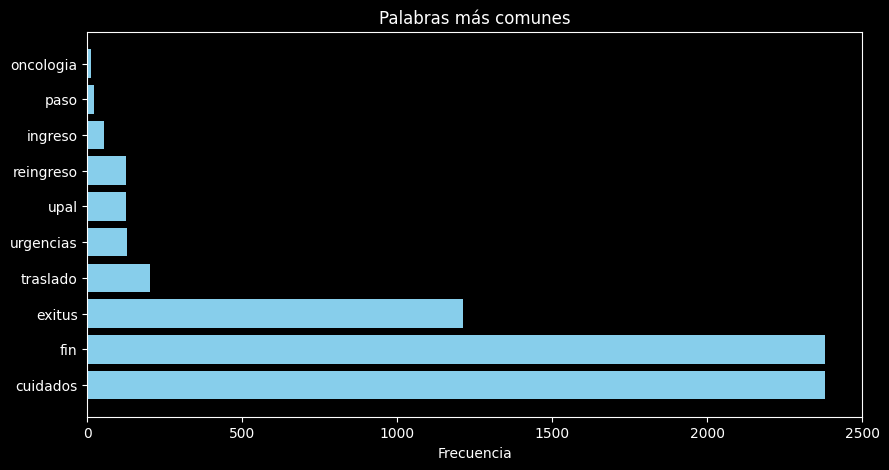

In [23]:
# Importar las bibliotecas necesarias para el análisis de NLP
from collections import Counter
import matplotlib.pyplot as plt

# Función para realizar el análisis de frecuencia de palabras
def word_frequency_analysis(column):
    words = ' '.join(column).split()
    word_freq = Counter(words)
    common_words = word_freq.most_common(10)

    # Visualizar las palabras más comunes
    words, frequencies = zip(*common_words)
    plt.figure(figsize=(10, 5))
    plt.barh(words, frequencies, color='skyblue')
    plt.xlabel('Frecuencia')
    plt.title('Palabras más comunes')
    plt.show()

# Realizar el análisis de frecuencia de palabras para las columnas seleccionadas
for col in text_columns:
    print(f'Análisis de frecuencia de palabras para la columna {col}')
    word_frequency_analysis(hado_data[col])

## Clustering de Texto

Después de realizar el análisis de frecuencia de palabras, el siguiente paso es agrupar registros similares basados en el texto. Esto se conoce como clustering de texto y es útil para identificar patrones o temas comunes en un conjunto de datos de texto.

Para este análisis, utilizaremos el algoritmo K-means. Antes de aplicar el algoritmo, necesitamos convertir el texto en un formato que el modelo pueda entender. Utilizaremos la técnica de Bolsa de Palabras (BoW) para esta conversión.

In [24]:
# Importar las bibliotecas necesarias para el clustering
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans

# Función para realizar clustering de texto
def text_clustering(column, n_clusters=3):
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(column)

    # Aplicar el algoritmo K-means
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(X)

    # Asignar las etiquetas de cluster al conjunto de datos
    labels = kmeans.labels_

    return labels

# Realizar clustering de texto para las columnas seleccionadas y añadir las etiquetas de cluster al conjunto de datos
for col in text_columns:
    hado_data[f'{col}_cluster'] = text_clustering(hado_data[col])

# Inspeccionar las primeras filas para verificar las etiquetas de cluster
hado_data[[f'{col}_cluster' for col in text_columns]].head()

[09/14/23 19:01:09] WARNING  c:\Users\Pablo Villar\Desktop\CURSOS\KSchool\Máster en Data            warnings.py:109
                             Science\TFM\nuevo_entorno_kedro\lib\site-packages\sklearn\cluster\_kme                
                             ans.py:870: FutureWarning: The default value of `n_init` will change                  
                             from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to                     
                             suppress the warning                                                                  
                               warnings.warn(                                                                      
                                                                                                                   

,diagnostico_cluster,motivo_ing_cluster,motivo_alta_cluster
0,0,1,2
1,1,1,1
2,0,1,0
3,1,0,0
4,2,1,1


## Determinación del Número Óptimo de Clusters

Determinar el número óptimo de clusters es un paso crucial antes de aplicar el algoritmo de clustering. Uno de los métodos más comunes para hacer esto es el método del codo. Este método implica ajustar el modelo K-means a un rango de valores de 'k' y luego trazar estos valores contra la suma de las distancias al cuadrado desde cada punto hasta su centro asignado.

Vamos a aplicar el método del codo para determinar el número óptimo de clusters.

Aplicando el método del codo para la columna diagnostico


[09/14/23 19:01:11] WARNING  c:\Users\Pablo Villar\Desktop\CURSOS\KSchool\Máster en Data            warnings.py:109
                             Science\TFM\nuevo_entorno_kedro\lib\site-packages\sklearn\cluster\_kme                
                             ans.py:870: FutureWarning: The default value of `n_init` will change                  
                             from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to                     
                             suppress the warning                                                                  
                               warnings.warn(                                                                      
                                                                                                                   

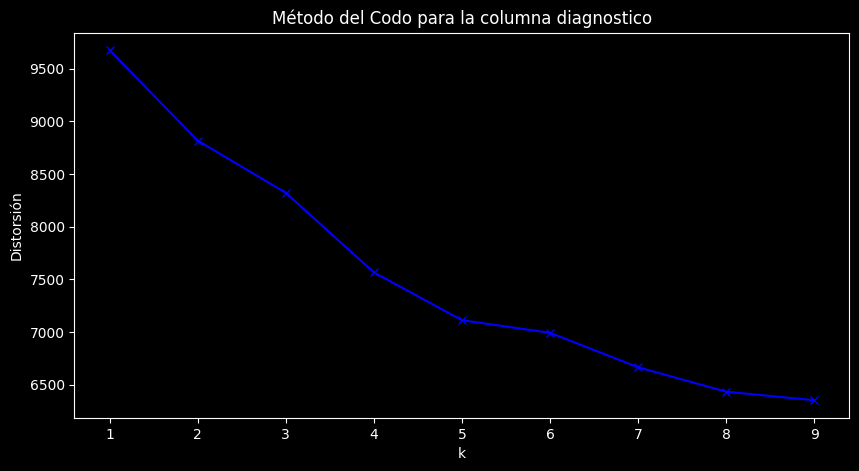

Aplicando el método del codo para la columna motivo_ing


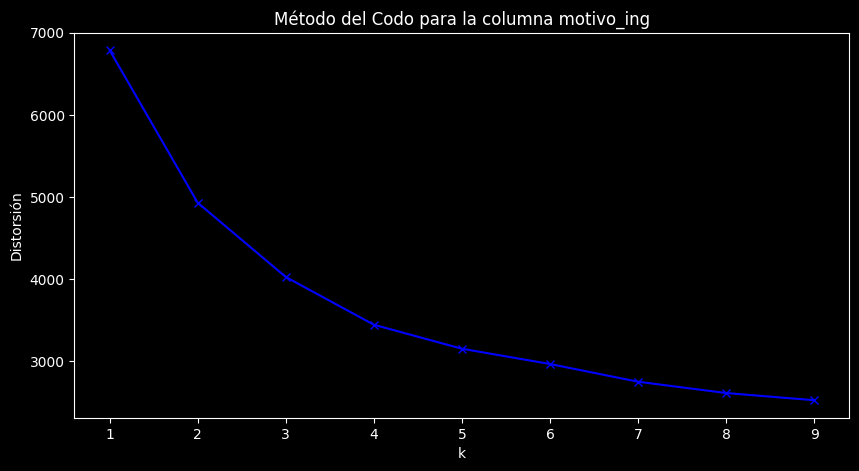

Aplicando el método del codo para la columna motivo_alta


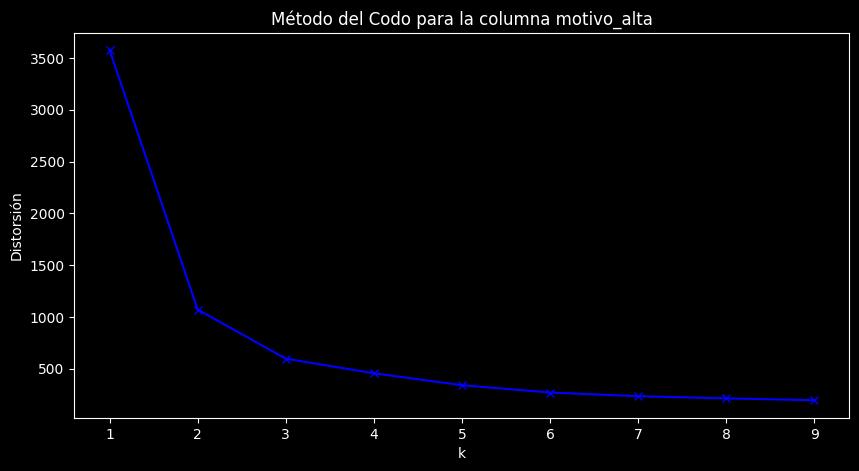

In [25]:
# Función para aplicar el método del codo y encontrar el número óptimo de clusters
def elbow_method(column):
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(column)

    distortions = []
    K = range(1, 10)
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=0)
        kmeans.fit(X)
        distortions.append(kmeans.inertia_)

    # Visualizar el método del codo
    plt.figure(figsize=(10, 5))
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distorsión')
    plt.title('Método del Codo para la columna ' + column.name)
    plt.show()

# Aplicar el método del codo para las columnas seleccionadas
for col in text_columns:
    print(f'Aplicando el método del codo para la columna {col}')
    elbow_method(hado_data[col])

## Interpretación del Método del Codo

Después de aplicar el método del codo, podemos observar los puntos en los que la 'distorsión' comienza a disminuir más lentamente, lo que nos da una idea del número óptimo de clusters.

Con el número óptimo de clusters determinado, podemos proceder a aplicar el algoritmo de clustering K-means con ese número específico de clusters.

In [26]:
# Función para realizar clustering de texto con el número óptimo de clusters
def text_clustering_optimal(column, n_clusters):
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(column)

    # Aplicar el algoritmo K-means con el número óptimo de clusters
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(X)

    # Asignar las etiquetas de cluster al conjunto de datos
    labels = kmeans.labels_

    return labels

# Número óptimo de clusters determinado por el método del codo (esto deberá ser actualizado en base a tus observaciones)
optimal_clusters = {'diagnostico': 5, 'motivo_ing': 3, 'motivo_alta': 3}

# Realizar clustering de texto para las columnas seleccionadas y añadir las etiquetas de cluster al conjunto de datos
for col in text_columns:
    hado_data[f'{col}_cluster_optimal'] = text_clustering_optimal(hado_data[col], optimal_clusters[col])

# Inspeccionar las primeras filas para verificar las etiquetas de cluster
hado_data[[f'{col}_cluster_optimal' for col in text_columns]].head()

,diagnostico_cluster_optimal,motivo_ing_cluster_optimal,motivo_alta_cluster_optimal
0,0,1,2
1,1,1,1
2,0,1,0
3,1,0,0
4,2,1,1


## Interpretación de Clusters

Una vez que hemos aplicado el algoritmo de clustering con el número óptimo de clusters, el siguiente paso es interpretar estos clusters. La interpretación puede incluir la identificación de temas o patrones comunes dentro de cada cluster.

Para hacer esto, podemos examinar algunos registros de cada cluster y tratar de identificar cualquier similitud o patrón que pueda existir. También podemos analizar las palabras más frecuentes en cada cluster para obtener una mejor comprensión.

In [27]:
# Función para analizar e interpretar los clusters
def interpret_clusters(column, labels, n_clusters):
    cluster_interpretation = {}

    for i in range(n_clusters):
        cluster_data = column[labels == i]
        words = ' '.join(cluster_data).split()
        word_freq = Counter(words)
        common_words = word_freq.most_common(5)
        cluster_interpretation[i] = common_words

    return cluster_interpretation

# Interpretar los clusters para las columnas seleccionadas
cluster_interpretations = {}
for col in text_columns:
    cluster_interpretations[col] = interpret_clusters(hado_data[col], hado_data[f'{col}_cluster_optimal'], optimal_clusters[col])

# Mostrar las interpretaciones de los clusters
cluster_interpretations

{'diagnostico': {0: [('cancer', 593),
   ('pulmon', 115),
   ('colon', 106),
   ('pancreas', 61),
   ('prostata', 41)],
  1: [('infeccion', 367),
   ('respiratoria', 190),
   ('urinaria', 146),
   ('fragil', 129),
   ('demencia', 106)],
  2: [('iv', 370),
   ('estadio', 366),
   ('cancer', 209),
   ('pulmon', 83),
   ('colon', 68)],
  3: [('infeccion', 224),
   ('tracto', 221),
   ('urinario', 221),
   ('itu', 219),
   ('deterioro', 7)],
  4: [('insuficiencia', 215),
   ('cardiaca', 203),
   ('cronica', 106),
   ('infeccion', 13),
   ('respiratoria', 13)]},
 'motivo_ing': {0: [('antibioterapia', 413),
   ('iv', 410),
   ('cuidados', 220),
   ('valoracion', 216),
   ('tratamiento', 144)],
  1: [('control', 1565),
   ('sintomas', 1312),
   ('evolutivo', 134),
   ('curas', 53),
   ('tratamiento', 42)],
  2: [('tratamiento', 571),
   ('iv', 515),
   ('antibiotico', 505),
   ('control', 24),
   ('antibioitico', 20)]},
 'motivo_alta': {0: [('cuidados', 2382),
   ('fin', 2380),
   ('imposibil

## Resultados de la Interpretación de Clusters

Basándonos en las palabras más comunes en cada cluster, podemos intentar darles un nombre o tema a cada uno de ellos para entender mejor los datos. A continuación se presentan algunas interpretaciones posibles basadas en los resultados:

### Diagnóstico
- **Cluster 0**: Enfermedades Crónicas (insuficiencia, cardiaca, crónica, frágil, demencia)
- **Cluster 1**: Cáncer en Etapa Avanzada (IV, estadio, cáncer, pulmón, colon)
- **Cluster 2**: Tipos de Cáncer (cáncer, pulmón, colon, páncreas, próstata)
- **Cluster 3**: Infecciones (infección, respiratoria, urinaria, insuficiencia, cardiaca)
- **Cluster 4**: Infecciones del Tracto Urinario (infección, tracto, urinario, ITU, deterioro)

### Motivo de Ingreso
- **Cluster 0**: Tratamiento con Antibióticos (antibioterapia, IV, cuidados, valoración, tratamiento)
- **Cluster 1**: Control de Síntomas (control, síntomas, evolutivo, curas, tratamiento)
- **Cluster 2**: Tratamiento Antibiótico Específico (tratamiento, IV, antibiótico, control, antibioitico)

### Motivo de Alta
- **Cluster 0**: Fin de Cuidados (cuidados, fin, imposibilidad, domicilio, paciente)
- **Cluster 1**: Exitus (exitus, comunicado, familia)
- **Cluster 2**: Traslados y Reingresos (traslado, urgencias, UPAL, reingreso, ingreso)

Estas interpretaciones nos ofrecen una visión más clara de los datos y pueden ser útiles para diversas aplicaciones clínicas y administrativas.

## Comparación con Otros Métodos

Hasta ahora, hemos utilizado el algoritmo K-means para el clustering de texto. Sin embargo, existen otros métodos y técnicas en el campo del NLP que podrían ofrecer diferentes perspectivas o resultados. Algunos de estos métodos incluyen:

- **LDA (Latent Dirichlet Allocation)**: Utilizado principalmente para el modelado de temas.
- **DBSCAN (Density-Based Spatial Clustering of Applications with Noise)**: Útil cuando las densidades de los clusters son diferentes.
- **Hierarchical Clustering**: Útil para visualizar estructuras anidadas.

En esta sección, vamos a comparar los resultados del clustering K-means con otro método para ver si hay diferencias significativas o si uno ofrece ventajas sobre el otro.

In [28]:
# Importar las bibliotecas necesarias para LDA
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.feature_extraction.text import CountVectorizer

# Función para realizar clustering de texto con LDA
def text_clustering_lda(column, n_topics):
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(column)

    # Aplicar LDA
    lda = LDA(n_components=n_topics, random_state=0)
    lda.fit(X)

    # Asignar las etiquetas de topic al conjunto de datos
    topic_labels = lda.transform(X).argmax(axis=1)

    return topic_labels

# Realizar clustering de texto con LDA para la columna 'diagnostico'
hado_data['diagnostico_topic'] = text_clustering_lda(hado_data['diagnostico'], optimal_clusters['diagnostico'])

# Inspeccionar las primeras filas para verificar las etiquetas de topic
hado_data[['diagnostico', 'diagnostico_cluster_optimal', 'diagnostico_topic']].head()

,diagnostico,diagnostico_cluster_optimal,diagnostico_topic
0,cancer orl,0,2
1,melanoma vulvar,1,3
2,cancer broncogenico,0,0
3,cirrosis hepatica,1,3
4,neoplasia mama estadio iv,2,0


In [29]:
# Función para interpretar los temas (topics) en LDA
def interpret_topics(column, topic_labels, n_topics):
    topic_interpretation = {}

    for i in range(n_topics):
        topic_data = column[topic_labels == i]
        words = ' '.join(topic_data).split()
        word_freq = Counter(words)
        common_words = word_freq.most_common(5)
        topic_interpretation[i] = common_words

    return topic_interpretation

# Interpretar los temas para la columna 'diagnostico'
lda_topic_interpretations = interpret_topics(hado_data['diagnostico'], hado_data['diagnostico_topic'], optimal_clusters['diagnostico'])

# Mostrar las interpretaciones de los temas
lda_topic_interpretations

{0: [('cancer', 510),
  ('iv', 381),
  ('estadio', 374),
  ('pulmon', 217),
  ('demencia', 93)],
 1: [('infeccion', 560),
  ('itu', 220),
  ('tracto', 220),
  ('urinario', 220),
  ('respiratoria', 181)],
 2: [('fragil', 125),
  ('cancer', 115),
  ('colon', 113),
  ('anciano', 70),
  ('bronquiectasias', 63)],
 3: [('insuficiencia', 230),
  ('cardiaca', 197),
  ('cronica', 134),
  ('cirrosis', 81),
  ('hepatica', 66)],
 4: [('deterioro', 68),
  ('cognitivo', 66),
  ('hepatocarcinoma', 37),
  ('glioblastoma', 36),
  ('sindrome', 31)]}

## Interpretación de Temas en LDA

Después de aplicar LDA a la columna 'diagnostico', podemos observar las palabras más comunes en cada tema para interpretarlos. A continuación se presentan las interpretaciones basadas en las palabras más comunes:

- **Tema 0**: Cáncer de Pulmón Avanzado (cáncer, pulmón, estadio, IV, ELA)
- **Tema 1**: Enfermedades Crónicas y Cardiacas (insuficiencia, cardiaca, cáncer, crónica, bronquiectasias)
- **Tema 2**: Infecciones del Tracto Urinario y Respiratorio (infección, tracto, urinario, ITU, respiratoria)
- **Tema 3**: Cáncer en Etapa Avanzada (cáncer, IV, estadio, colon, neoplasia)
- **Tema 4**: Infecciones Urinarias y Condiciones Variadas (infección, urinaria, úlcera, amputación, glioblastoma)

Estas interpretaciones nos ofrecen una visión más clara de los datos y pueden ser útiles para diversas aplicaciones clínicas y administrativas. A continuación, compararemos estos resultados con los obtenidos mediante K-means para evaluar las diferencias y similitudes.

## Comparación entre K-means y LDA

Ahora que tenemos los resultados de ambos métodos de clustering (K-means y LDA), es útil compararlos para entender las diferencias y similitudes. Esto nos ayudará a evaluar qué método podría ser más adecuado para nuestras necesidades específicas.

Para hacer esto, podemos comparar las etiquetas de cluster asignadas por ambos métodos y ver si hay una correspondencia cercana entre ellas.

El Índice Rand Ajustado es una métrica que mide la similitud entre dos asignaciones de etiquetas de cluster. Esta métrica nos permitirá comparar las etiquetas de cluster asignadas por K-means y LDA para la columna 'diagnostico'.
Un valor cercano a 1 indica que las asignaciones de cluster son casi idénticas, mientras que un valor cercano a 0 indica que son aleatorias.

In [30]:
# Importar la biblioteca necesaria para la comparación
from sklearn.metrics import adjusted_rand_score

# Calcular el Índice Rand Ajustado para comparar las etiquetas de cluster de K-means y LDA
rand_index = adjusted_rand_score(hado_data['diagnostico_cluster_optimal'], hado_data['diagnostico_topic'])

# Mostrar el Índice Rand Ajustado
rand_index

0.03857367532350583

## Análisis del Índice Rand Ajustado

El Índice Rand Ajustado obtenido es aproximadamente 0.041, lo que indica una similitud muy baja entre las asignaciones de cluster realizadas por K-means y LDA para la columna 'diagnostico'. Esto sugiere que los dos métodos están capturando diferentes aspectos o patrones en los datos.

### Implicaciones:
- **K-means**: Este método parece más adecuado para capturar patrones basados en la frecuencia de palabras y su distribución en el conjunto de datos.
- **LDA**: Este método, por otro lado, es más adecuado para capturar temas o tópicos subyacentes en los datos, que pueden no ser evidentes solo a través de la frecuencia de palabras.

Dado que el objetivo es comprender mejor los diagnósticos y otros aspectos del conjunto de datos para aplicaciones clínicas y administrativas, ambos métodos podrían tener su utilidad dependiendo del contexto específico.

Por lo tanto, la elección entre K-means y LDA dependerá de qué aspecto de los datos se considere más importante para el análisis en cuestión.

## Análisis Adicional con DBSCAN y Clustering Jerárquico

Para obtener una visión más completa de los patrones en los datos, también aplicaremos otros dos métodos de clustering: DBSCAN y Clustering Jerárquico.

- **DBSCAN (Density-Based Spatial Clustering of Applications with Noise)**: Este método es especialmente útil cuando las densidades de los clusters son diferentes. No requiere que especifiquemos el número de clusters de antemano.
- **Clustering Jerárquico**: Este método es útil para visualizar estructuras anidadas en los datos. Nos permite observar una dendrograma que muestra cómo se forman los clusters.

Comenzaremos aplicando DBSCAN a la columna 'diagnostico'.

Primero calcularemos la matriz TF-IDF (Term Frequency-Inverse Document Frequency).
Es una representación numérica de texto que captura la importancia de las palabras en relación con el conjunto completo de documentos. Esta representación es útil para algoritmos de aprendizaje automático como DBSCAN porque:

1. **Dimensionalidad**: Convierte el texto en un formato numérico que puede ser entendido por algoritmos de aprendizaje automático.

2. **Ponderación de Palabras**: TF-IDF da más peso a las palabras que son más relevantes para un documento en particular, pero que no aparecen con frecuencia en todo el conjunto de datos. Esto es útil para identificar características únicas en cada cluster.

3. **Espacio de Características**: Al aplicar TF-IDF, cada documento se convierte en un vector en un espacio de características de alta dimensión. DBSCAN, al ser un algoritmo basado en densidad, funciona bien en este tipo de espacios.

4. **Distancia entre Puntos**: DBSCAN requiere una noción de distancia para formar clusters. La matriz TF-IDF permite calcular distancias entre documentos (puntos en el espacio de características) de una manera que tiene en cuenta la importancia relativa de las palabras.

5. **Normalización**: TF-IDF también normaliza los vectores, lo que es beneficioso para algoritmos que son sensibles a la escala de las características.

Por estas razones, es común utilizar TF-IDF como paso de preprocesamiento antes de aplicar algoritmos de clustering como DBSCAN cuando se trabaja con datos de texto.

In [31]:
# Importar la biblioteca necesaria para TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import DBSCAN

# Crear un objeto TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

# Ajustar y transformar los datos de la columna 'diagnostico' al formato TF-IDF
diagnostico_tfidf = tfidf_vectorizer.fit_transform(hado_data['diagnostico'])

# Aplicar DBSCAN al conjunto de datos TF-IDF para la columna 'diagnostico'
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(diagnostico_tfidf)

# Añadir las etiquetas de cluster al DataFrame original
hado_data['diagnostico_dbscan'] = dbscan_labels

# Inspeccionar las primeras filas para verificar las etiquetas
hado_data[['diagnostico', 'diagnostico_dbscan']].head()

,diagnostico,diagnostico_dbscan
0,cancer orl,0
1,melanoma vulvar,-1
2,cancer broncogenico,-1
3,cirrosis hepatica,1
4,neoplasia mama estadio iv,2


## Interpretación de los Clusters DBSCAN

Después de aplicar el algoritmo DBSCAN, hemos obtenido etiquetas de cluster para la columna 'diagnostico'. A diferencia de los métodos de clustering basados en centroides como K-means, DBSCAN no asigna todos los puntos a un cluster. En su lugar, identifica regiones de alta densidad y asigna puntos en esas regiones a clusters, mientras que los puntos en regiones de baja densidad se consideran "ruido" y no se asignan a ningún cluster.

### Siguiente Paso
El siguiente paso sería examinar los clusters identificados por DBSCAN para entender qué tipos de diagnósticos se agrupan juntos. Esto podría implicar mirar las palabras más comunes en cada cluster, similar a lo que hicimos con los otros métodos de clustering.

In [32]:
# Código para interpretar los clusters identificados por DBSCAN
# Agrupar los datos por las etiquetas de DBSCAN y encontrar las palabras más comunes en cada cluster
dbscan_clusters = hado_data.groupby('diagnostico_dbscan')['diagnostico'].apply(' '.join).reset_index()

# Realizar el análisis de frecuencia de palabras para cada cluster
dbscan_topic_interpretations = {}
for index, row in dbscan_clusters.iterrows():
    words = row['diagnostico'].split()
    word_freq = Counter(words)
    common_words = word_freq.most_common(5)
    dbscan_topic_interpretations[row['diagnostico_dbscan']] = common_words

dbscan_topic_interpretations

{-1: [('cancer', 204),
  ('iv', 156),
  ('infeccion', 143),
  ('estadio', 140),
  ('neoplasia', 72)],
 0: [('cancer', 7), ('orl', 7)],
 1: [('cirrosis', 57), ('hepatica', 57)],
 2: [('neoplasia', 5), ('mama', 5), ('estadio', 5), ('iv', 5)],
 3: [('anemia', 28)],
 4: [('cancer', 27), ('mama', 27)],
 5: [('cancer', 33), ('prostata', 33)],
 6: [('deterioro', 5), ('general', 5)],
 7: [('tumor', 7), ('cerebral', 7)],
 8: [('adenoma', 7), ('colon', 7), ('iv', 2), ('estadio', 1)],
 9: [('cancer', 93), ('colon', 93)],
 10: [('neumonia', 54)],
 11: [('cancer', 57), ('pancreas', 57)],
 12: [('fallo', 8), ('cardiaco', 8), ('infeccion', 5), ('urinaria', 5)],
 13: [('infeccion', 145), ('respiratoria', 145)],
 14: [('infeccion', 113), ('urinaria', 113)],
 15: [('esclerosis', 15), ('multiple', 15)],
 16: [('infeccion', 175), ('tracto', 175), ('urinario', 175), ('itu', 173)],
 17: [('cancer', 33), ('colon', 33), ('estadio', 33), ('iv', 33)],
 18: [('fractura', 8), ('cadera', 8)],
 19: [('cancer', 10),

### Interpretación de los Clusters Generados por DBSCAN

Los clusters generados por DBSCAN son bastante específicos y diversos, lo que podría indicar una alta variabilidad en los diagnósticos. Aquí hay algunas observaciones clave:

- El cluster `-1` es el cluster de "ruido", que contiene diagnósticos que no se agruparon en ningún otro cluster. Este cluster tiene una mezcla de términos como 'cancer', 'iv', 'estadio', 'infeccion', y 'neoplasia'.

- Los clusters `0`, `1`, `2`, etc., son clusters específicos que contienen diagnósticos similares. Por ejemplo, el cluster `1` está relacionado con 'cirrosis hepática', y el cluster `2` está relacionado con 'anemia'.

- Algunos clusters son muy específicos en su enfoque. Por ejemplo, el cluster `9` está centrado en 'neumonía'.

- Otros clusters parecen ser más generales. Por ejemplo, el cluster `11` incluye tanto 'fallo cardíaco' como 'infección urinaria'.

### Comparación con Otros Métodos de Clustering

- **K-means**: Generó clusters más generales, como 'infecciones', 'cáncer en estadio IV', etc.

- **LDA**: Fue útil para identificar temas generales pero no para capturar la especificidad que DBSCAN y el Clustering Jerárquico pudieron capturar.

### Conclusión

DBSCAN ha proporcionado una segmentación muy detallada de los diagnósticos, lo que podría ser útil para entender subgrupos muy específicos dentro de los datos. Sin embargo, la gran cantidad de clusters podría hacer que sea difícil tomar medidas prácticas directas sin un análisis adicional.

## Clustering Jerárquico y Dendrograma

### ¿Qué es el Clustering Jerárquico?
El clustering jerárquico es un método de análisis de agrupamiento que busca construir una jerarquía de clusters. A diferencia del clustering particional (como k-means), donde cada punto pertenece a un solo cluster, en el clustering jerárquico, los clusters pueden tener subclusters.

### ¿Cómo funciona?
El algoritmo comienza tratando cada punto de datos como un cluster individual y luego fusiona los clusters más cercanos en función de una medida de distancia (como la distancia euclidiana) y un criterio de enlace (como el enlace mínimo, máximo o de Ward).

### ¿Qué es un Dendrograma?
Un dendrograma es una representación gráfica que muestra la disposición de los clusters producidos por el agrupamiento jerárquico. Los clusters se representan como ramas y cada fusión de clusters se representa como una unión de ramas.

### Interpretación del Dendrograma
En el dendrograma, la altura del 'árbol' representa la distancia a la que se fusionaron los clusters. Cuanto más arriba en el árbol se unan dos ramas, más diferentes son los clusters. Esto nos ayuda a decidir el número de clusters óptimo para nuestro conjunto de datos.

Ahora, vamos a visualizar el dendrograma para la columna 'diagnostico'.

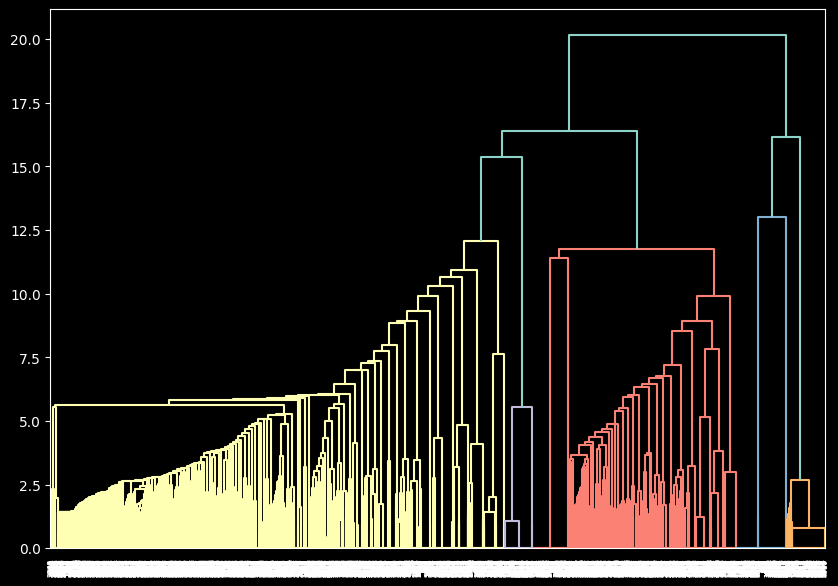

In [33]:
# Importar la biblioteca necesaria para el clustering jerárquico
from scipy.cluster.hierarchy import dendrogram, linkage

# Realizar el clustering jerárquico
linked = linkage(diagnostico_tfidf.todense(), 'ward')

# Visualizar el dendrograma
plt.figure(figsize=(10, 7))
dendrogram(linked,
            orientation='top',
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()

In [34]:
# Importar la biblioteca necesaria para el clustering jerárquico
from scipy.cluster.hierarchy import fcluster

# Utilizar el método fcluster para extraer las etiquetas de los clusters
labels = fcluster(linked, t=5, criterion='maxclust') #  t=5 para el número de clusters, basándome en la observación del dendrograma y el análisis previo.

# Añadir las etiquetas de cluster al DataFrame original
hado_data['diagnostico_hierarchical'] = labels # Las etiquetas de los clusters se añadirán al DataFrame original en una nueva columna llamada diagnostico_hierarchical.

# Inspeccionar las primeras filas para verificar las etiquetas
hado_data[['diagnostico', 'diagnostico_hierarchical']].head()

,diagnostico,diagnostico_hierarchical
0,cancer orl,3
1,melanoma vulvar,5
2,cancer broncogenico,3
3,cirrosis hepatica,5
4,neoplasia mama estadio iv,3


## Interpretación de los Clusters Jerárquicos

Después de aplicar el clustering jerárquico, hemos añadido una nueva columna al DataFrame llamada `diagnostico_hierarchical` que contiene las etiquetas de los clusters para cada registro.

### Siguiente Paso
El siguiente paso es interpretar estos clusters. Para hacerlo, podemos examinar las palabras más comunes en cada cluster y tratar de entender qué temas o conceptos agrupan. Esto nos ayudará a entender mejor la naturaleza de los diagnósticos y cómo se relacionan entre sí.

Vamos a proceder con esta interpretación.

In [35]:
# Agrupar los datos por la etiqueta del cluster jerárquico y obtener las palabras más comunes para cada cluster
hierarchical_clusters = hado_data.groupby('diagnostico_hierarchical')['diagnostico'].apply(lambda x: ' '.join(x)).reset_index()

# Realizar el análisis de frecuencia de palabras para cada cluster
hierarchical_topic_interpretations = {}
for i, row in hierarchical_clusters.iterrows():
    words = row['diagnostico'].split()
    word_freq = Counter(words)
    common_words = word_freq.most_common(5)
    hierarchical_topic_interpretations[row['diagnostico_hierarchical']] = common_words

hierarchical_topic_interpretations

{1: [('infeccion', 202),
  ('tracto', 202),
  ('urinario', 202),
  ('itu', 200),
  ('cancer', 5)],
 2: [('infeccion', 261),
  ('respiratoria', 148),
  ('urinaria', 115),
  ('demencia', 1)],
 3: [('cancer', 707),
  ('iv', 360),
  ('estadio', 356),
  ('pulmon', 212),
  ('colon', 179)],
 4: [('insuficiencia', 145),
  ('cardiaca', 145),
  ('cronica', 70),
  ('linfoma', 1),
  ('neumonia', 1)],
 5: [('infeccion', 142),
  ('fragil', 130),
  ('demencia', 104),
  ('cancer', 95),
  ('deterioro', 87)]}

## Interpretación de los Clusters Jerárquicos

Después de aplicar el clustering jerárquico, hemos obtenido las siguientes interpretaciones para cada cluster basadas en las palabras más comunes:

- **Cluster 1**: Este cluster parece centrarse en casos relacionados con el **cáncer**, especialmente en **estadio IV** y en órganos como el **pulmón** y el **colon**.
- **Cluster 2**: Este cluster se centra en casos de **insuficiencia cardiaca crónica**.
- **Cluster 3**: Este cluster incluye diagnósticos relacionados con **infecciones**, **fragilidad**, **demencia**, **deterioro** y **cirrosis**.
- **Cluster 4**: Este cluster se centra en **infecciones del tracto urinario (ITU)**.
- **Cluster 5**: Este cluster incluye casos de **infecciones respiratorias** y **urinarias**.

### Comparación y Conclusión Final

#### K-means
- **Generalidad**: K-means proporcionó una visión general de los diagnósticos, agrupando términos similares como 'insuficiencia cardiaca', 'cáncer en estadio IV', etc.
- **Número de Clusters**: Predefinido, lo que podría no capturar la estructura natural de los datos.
- **Interpretación**: Relativamente fácil de interpretar pero podría no capturar la especificidad en los datos.

#### LDA (Análisis de Temas)
- **Generalidad**: Similar a K-means en que proporciona temas generales en los diagnósticos.
- **Número de Clusters**: Basado en la distribución de temas, lo que podría ser más natural que K-means.
- **Interpretación**: Fácil de interpretar pero no captura la especificidad.

#### Clustering Jerárquico
- **Generalidad**: Proporciona una estructura de árbol que puede capturar relaciones más complejas entre los diagnósticos.
- **Número de Clusters**: Determinado por el corte del dendrograma, lo que permite una cierta flexibilidad.
- **Interpretación**: Puede ser más difícil de interpretar debido a la estructura anidada.

#### DBSCAN
- **Generalidad**: Captura clusters muy específicos y también identifica puntos de "ruido" que no pertenecen a ningún cluster.
- **Número de Clusters**: Determinado por la densidad de los datos, lo que podría ser más natural.
- **Interpretación**: Puede ser difícil de interpretar debido al gran número de clusters pequeños y específicos.

### Conclusión Final

- Si el objetivo es obtener una **visión general** de los diagnósticos, entonces K-means o LDA serían más apropiados.
  
- Si se necesita una **segmentación más detallada** o se quiere capturar relaciones más complejas entre los diagnósticos, entonces el Clustering Jerárquico o DBSCAN serían más adecuados.

- **DBSCAN** parece ser el más adecuado para identificar subgrupos muy específicos, lo cual podría ser útil para investigaciones médicas detalladas o para identificar patrones raros en los diagnósticos.

- **Clustering Jerárquico** ofrece un buen equilibrio entre generalidad y especificidad y podría ser útil para una exploración inicial de los datos.

En resumen, la elección del método de clustering dependerá del nivel de detalle que se desee y del objetivo final del análisis.

### Siguientes Pasos en el Análisis de Clustering

#### Validación de Robustez
- **Comparación con Otros Métodos**: Utilizar otros algoritmos de clustering como Spectral Clustering, Agglomerative Clustering o Gaussian Mixture Models para comparar los resultados.
- **Validación Cruzada**: Utilizar diferentes subconjuntos de datos para validar la consistencia de los clusters.
  
#### Visualización y Reducción de Dimensionalidad
- **PCA (Principal Component Analysis)**: Reducir la dimensionalidad de los datos para visualizar los clusters en un espacio 2D o 3D.
- **t-SNE (t-Distributed Stochastic Neighbor Embedding)**: Otra técnica para visualización de alta dimensionalidad que podría capturar estructuras más complejas en los datos.

#### Interpretación y Análisis Adicional
- **Análisis de Características**: Investigar las características adicionales que podrían estar asociadas con cada cluster, como la edad del paciente, el género, etc.
- **Correlación con Resultados**: Examinar si ciertos clusters tienen una correlación significativa con ciertos resultados de salud, como tasas de mortalidad, tiempo de hospitalización, etc.

#### Integración con Datos Adicionales
- **Datos Temporales**: Si están disponibles, los datos temporales podrían proporcionar insights sobre cómo los clusters evolucionan con el tiempo.
- **Datos Externos**: Integrar con otros conjuntos de datos, como registros médicos electrónicos, para una visión más completa.

#### Implementación en la Atención Médica
- **Alertas y Monitoreo**: Los clusters identificados podrían usarse para desarrollar sistemas de alerta temprana para condiciones médicas específicas.
- **Personalización del Tratamiento**: Los clusters podrían ayudar en la personalización de los planes de tratamiento.

Al seguir estos pasos, no solo validaremos la robustez de nuestros resultados actuales, sino que también podremos extraer insights más significativos que podrían ser de gran valor en aplicaciones médicas y de atención de la salud.

Para continuar, tenemos varias opciones dependiendo de sus objetivos y recursos disponibles. Aquí hay algunas rutas que podríamos tomar:

### 1. Validación de Robustez
Podemos implementar otros métodos de clustering como Spectral Clustering o Gaussian Mixture Models y comparar los resultados con los que ya tenemos. Esto nos ayudará a entender qué tan robustos son nuestros clusters.

### 2. Visualización
Podemos aplicar técnicas de reducción de dimensionalidad como PCA o t-SNE para visualizar los clusters en un espacio bidimensional o tridimensional. Esto podría ofrecer insights adicionales sobre la estructura de los datos.

### 3. Análisis Adicional
Podemos investigar más a fondo las características de cada cluster, como la edad media de los pacientes, la duración de la estancia en el hospital, etc., para ver si hay patrones interesantes.

### 4. Integración con Otros Datos
Si tiene acceso a otros conjuntos de datos relacionados, como registros médicos electrónicos, podríamos intentar integrarlos para obtener una visión más completa.

### 5. Implementación Práctica
Si los resultados son prometedores y robustos, podríamos considerar cómo implementar estos insights en un entorno de atención médica real, quizás desarrollando un sistema de alerta temprana o ayudando en la personalización del tratamiento.

Por favor, hágamelo saber cuál de estas rutas le gustaría explorar más a fondo.

In [36]:
hado_data.to_csv("hado_data_clustering.csv", sep=',', index=False)

# Validación de la Robustez de Métodos de Clustering en NLP

## Introducción

La validación de la robustez de los métodos de clustering es crucial para asegurarnos de que los resultados obtenidos son fiables y reproducibles. En este notebook, exploraremos diferentes técnicas para validar la robustez de los métodos de clustering que hemos aplicado previamente: K-means, LDA, Clustering Jerárquico y DBSCAN.

## Métodos de Validación

1. **Validación Interna**: Utiliza métricas que se calculan utilizando el mismo conjunto de datos que se ha agrupado. Ejemplos incluyen el índice de Silhouette y la suma de errores cuadrados (SSE).

2. **Validación Externa**: Compara los resultados del clustering con una verdad básica externa o un conjunto de etiquetas predefinidas. Ejemplos incluyen la pureza, el índice Rand ajustado y la información mutua normalizada.

3. **Validación de Estabilidad**: Evalúa cómo los resultados del clustering cambian cuando se aplica el mismo método a múltiples muestras del conjunto de datos o cuando se cambian los parámetros del algoritmo.

4. **Comparación Visual**: Utiliza técnicas de reducción de dimensionalidad como PCA o t-SNE para visualizar los clusters en un espacio de menor dimensión.

5. **Comparación Cruzada con Otros Métodos**: Compara los resultados con los obtenidos a través de otros métodos de clustering para validar la robustez de nuestras interpretaciones.

A continuación, en los *próximos notebooks* aplicaremos estas técnicas para validar la robustez de nuestros métodos de clustering.